# Autoencoder with convolutional layers

Implementation of autoencoder with convolutional layers to MNIST dataset from PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else (
    torch.device('mps') if torch.backends.mps.is_available() else 'cpu'
)

print(f"device={device}")

device=cpu


In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform,
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform,
)

In [4]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False,
)

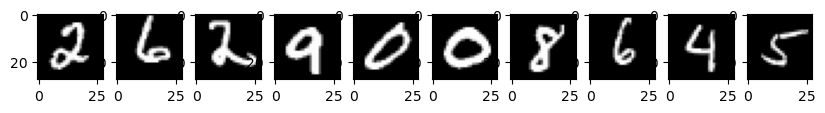

In [5]:
img = next(iter(train_loader))[0]
N = 10
fig, axs = plt.subplots(1, N, figsize=(10, 10))
plt.gray()
for i in range(N):
    axs[i].imshow(img[i][0])

In [6]:
print(f"Maximum value in image: {torch.max(img[0]).item()}")
print(f"Minimum value in image: {torch.min(img[0]).item()}")

Maximum value in image: 0.9960784316062927
Minimum value in image: 0.0


In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            # input: batch_size x 1 x 28 x 28
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # input: batch_size x 16 x 14 x 14
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # outpuit: batch_size x 32 x 7 x 7
        )

        self.decoder = nn.Sequential(
            # input: batch_size x 32 x 7 x 7
            nn.ConvTranspose2d(32, 16, stride=2, kernel_size=2),
            nn.ReLU(),
            # input: batch_size x 14 x 14
            nn.ConvTranspose2d(16, 1, stride=2, kernel_size=2),
            nn.Sigmoid(),
        )
    

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


def train(model, data_loader, dataset_size, n_epochs=2):
    model.train()
    output = []
    for epoch in range(1, n_epochs+1):
        losses = 0
        for (imgs, _) in data_loader:
            imgs = imgs.to(device)
            reconstructed_imgs = model(imgs)
            loss = criterion(reconstructed_imgs, imgs)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses += imgs.size(0) * loss.item()
            
        losses /= dataset_size
        print(f"epoch={epoch}, loss={losses:.4f}")
        output.append((epoch, losses))
    
    return output, model

In [9]:
output, model = train(
    model=model, 
    data_loader=train_loader, 
    dataset_size=len(train_dataset),
    n_epochs=20,
)

epoch=1, loss=0.0924
epoch=2, loss=0.0162
epoch=3, loss=0.0098
epoch=4, loss=0.0071
epoch=5, loss=0.0058
epoch=6, loss=0.0051
epoch=7, loss=0.0046
epoch=8, loss=0.0042
epoch=9, loss=0.0039
epoch=10, loss=0.0037
epoch=11, loss=0.0036
epoch=12, loss=0.0035
epoch=13, loss=0.0034
epoch=14, loss=0.0033
epoch=15, loss=0.0032
epoch=16, loss=0.0031
epoch=17, loss=0.0031
epoch=18, loss=0.0030
epoch=19, loss=0.0030
epoch=20, loss=0.0029


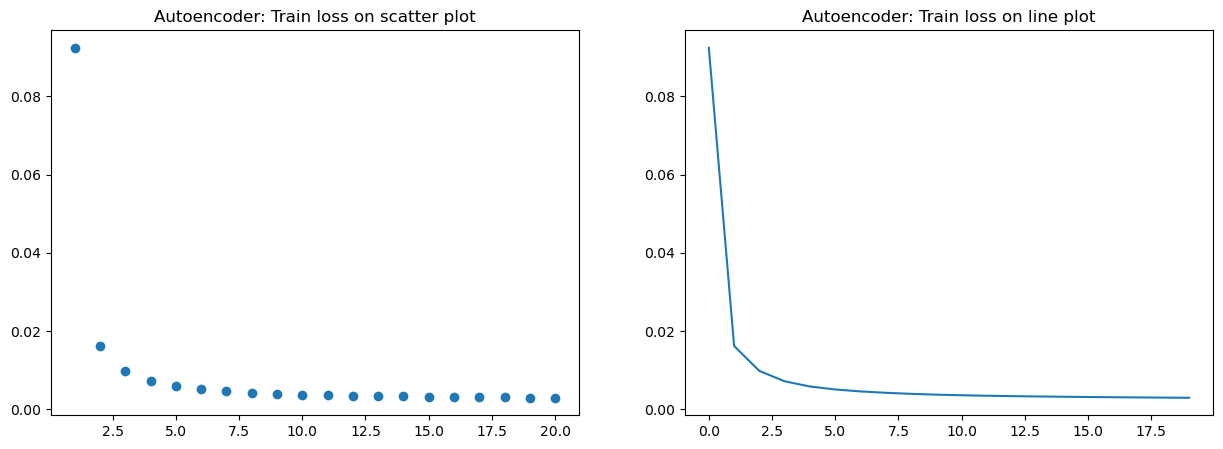

In [10]:
losses = [loss for _, loss in output]
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_title('Autoencoder: Train loss on scatter plot')
axs[0].scatter(x=range(1, 1+len(losses)), y=losses)
axs[1].plot(losses)
axs[1].set_title('Autoencoder: Train loss on line plot')
plt.show()

In [11]:
def test(model, data_loader, n_samples=10):
    assert n_samples < data_loader.batch_size
    
    fig, axs = plt.subplots(2, n_samples, figsize=(13, 3))
    fig.suptitle('First row is real images; Second row - reconstructed')
    
    MSE = 0
    
    model.eval()
    for (imgs, _) in data_loader:
        imgs = imgs.to(device)
        reconstructed_imgs = model(imgs)
        
        
        
        for i in range(n_samples):
            original_img = imgs[i].detach().numpy().reshape(28,28)
            reconstructed_img = reconstructed_imgs[i].detach().numpy().reshape(28,28)

            MSE += ((original_img - reconstructed_img)**2).sum()
            
            axs[0, i].imshow(original_img)
            axs[1, i].imshow(reconstructed_img)
            
        plt.show()
        
        break
        
    MSE /= n_samples
    
    print(f"MSE: {MSE}")

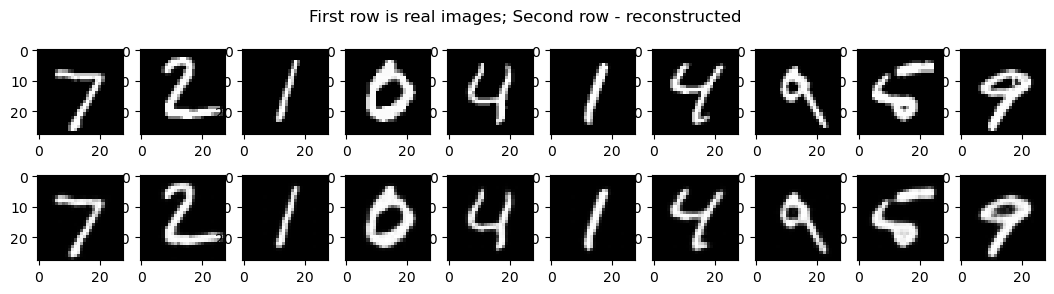

MSE: 1.6134971916675567


In [12]:
test(model=model, data_loader=test_loader)